# Mandatory assignment 2

INF5860 / INF9860 - Machine Learning for Image Analysis  
University of Oslo  
Spring 2018  
  
  
Handout: 02.03.2018  
Delivery deadline: 23.03.2018, 23:59]


## Image classification with deep learning and dense neural networks

In this exercise, you are supposed to implement a basic neural network for image classification. The network will be densly connected, with an arbitrary number of layers, and number of nodes in each layer. We shall implement a ReLu activation function, and use a softmax activation in the last layer. The error will be measured with a cross-entropy loss function, and the cost will be minimized using a stochastic gradient descent optimization routine.


### Evaluation format

You will be guided through the implementation step by step, and you can check your implementation at each step. Each subtask will be judged independently, so it should be possible to do one task even if you have not succeded in the previous. Note, however, that each step needs to be correct in order for the whole method to work at the end.

### Exercise content

- All subtasks that you are to answer is found in this notebook.
- In addition, there is a `src` folder that contains a skeleton for the classifier, including a complete way to import data.
- All implementation should be done in the respective files in the `src` folder

```
def implement_this_function(argument_1):
    """This is an illustrative dummy function"""
    # TODO: Task X.Y
    result = None
    
    return result
```
- Some function headers are already given, and necessary, as they are called by the subtasks in this notebook.
- Everything else you feel you need to implement, you can implement as you like.
- When you have implemented everything (correctly), you should be able to run the whole classifier as `python src/main.py`
- Suggestion about the values of different hyperparameters will be given, but you are encouraged to experiment in the final subtask.

### What you should implement

The skeleton of this program that is already implemented contains things such as:
- Program setup
- Configurations
- Data import of three datasets: mnist, cifar10, and svhn
- Training framework
- Evaluation framework

You should implement the content in the training framework. All steps will be given as tasks and subtasks below. The following are *you* supposed to implement.
1. Parameter initialization
2. Forward propagation through a network with *arbitrary number of layer* where each layer has an *arbitrary number of nodes*
  1. ReLu activation function
  2. Softmax function
  3. The rest of the forward propagation
3. Cross Entropy cost function
4. Backward propagation through network with *arbitrary number of layer* where each layer has an *arbitrary number of nodes*
  1. Derivative of the ReLu activation function
  2. The rest of the backwar propagation
5. Parameter update using Gradient Descent optimization
6. Run the finished method
  1. Reproduce result with default settings
  2. Exceed the default result by experimenting with different hyperparameter configurations.


### Additional notes

Most variables should be self-explanatory, but there are four important dictionaries worth mentioning, as they will control the data flow of the entire program

- `conf`: Contains all configurations of the program. These configurations will be passed around most functions, even though we most often will only need a couple of them; this is so that you are freer to experiment outside the boundaries of the program skeleton. They are set with some default values in the `config()` function in `src/main.py`.
- `params`: Contains all trainiable parameters, that is, all weight and bias arrays.
- `grads`: Contains the gradients of the respective trainable parameters.
- `features`: Contains input and output data, in addition to linear combination arrays `Z` and activation arrays `A`.

It is *strongly* encouraged to implement the vectorized version of things, otherwise, things are to slow.

This should be it. Let us begin.


### Notebook set up

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def compare_result(expected, proposed, name):
    """Compares the expected result agains the proposed result and prints some information"""
    if proposed is None:
        print("The {} does not seem to be implemented yet.".format(name))
        return
    if np.allclose(expected, proposed):
        print("Correct {}!".format(name))
    else:
        print("This does not seem entirely correct.")
        print("This could mean that there is something wrong with the implementation of {}.".format(name))
        print("The difference between expected and proposed result is")
        print(expected - proposed)

## Task 1: Parameter initialization

The function you are to implement is `initialization(layer_dimensions)`, located in `src/model.py`. The parameters shall have the following shape

$$
\begin{align}
    W^{[l]} &\in \mathbb{R}^{n^{[l-1]}\times n^{[l]}} \\
    b^{[l]} &\in \mathbb{R}^{n^{[l]}}
\end{align}
$$

and have the following values

$$
\begin{align}
    W_{jk}^{[l]} &\sim \mathcal{N}\left(0, \frac{2}{n^{[l-1]}}\right) \\
    b_k^{[l]} &= 0
\end{align}
$$

for all $j = 1, \ldots, n^{[l-1]}$, $k = 1, \ldots, n^{[l]}$, $l = 1, \ldots, L$. Here $x \sim \mathcal{N}(\mu, \sigma^2)$ means that $x$ is sampled from a normal (or gaussian) distribution with mean $\mu$ and variance $\sigma^2$. In order to achieve the normal sampling in python, you can use the `numpy.random.normal()` function.  

This initialization fits well with ReLu activations, and is proposed in [He et al. (2015)](https://arxiv.org/pdf/1502.01852.pdf). For another common initialization scheme, you can study the paper by [Glorot and Hinton (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

In [2]:
# Import the function you have implemented
from src.model import initialization

# This dummy network has 784 input nodes, two hidden layers with 128 and 32 nodes, respectively, and
# an output layer with 10 nodes
conf = {'layer_dimensions': [784, 128, 32, 10]}

# You should implement this function
params = initialization(conf)

# Check your results against the expected. Note that since we are dealing with (pseudo) randomness and
# small samples, the values of your array may differ some from the expected. But the absolute difference
# should not be very much larger than the order of 0.0001 for W_1, 0.001 for W_2, and 0.01 for W_3.
for key, value in sorted(params.items()):
    print("{}".format(key))
    print("    Shape = {}".format(value.shape))
    if key[0] == "W":
        n_lm1 = value.shape[0]
        print("    Mean: {0:>9.6f} vs {1:>9.6f} Abs diff: {2:>9.6f}".format(np.mean(value),
                                                                            0.0,
                                                                            np.abs(np.mean(value) - 0.0)))
        print("     Std: {0:>9.6f} vs {1:>9.6f} Abs diff: {2:>9.6f}".format(np.std(value),
                                                                            np.sqrt(2/n_lm1),
                                                                            np.abs(np.std(value) - np.sqrt(2/n_lm1))))
    else:
        print("     Min: {} vs {}".format(np.min(value), 0.0))
        print("     Max: {} vs {}".format(np.max(value), 0.0))

W_1
    Shape = (784, 128)
    Mean:  0.000138 vs  0.000000 Abs diff:  0.000138
     Std:  0.050557 vs  0.050508 Abs diff:  0.000050
W_2
    Shape = (128, 32)
    Mean:  0.002198 vs  0.000000 Abs diff:  0.002198
     Std:  0.123693 vs  0.125000 Abs diff:  0.001307
W_3
    Shape = (32, 10)
    Mean: -0.021219 vs  0.000000 Abs diff:  0.021219
     Std:  0.255675 vs  0.250000 Abs diff:  0.005675
b_1
    Shape = (128, 1)
     Min: 0.0 vs 0.0
     Max: 0.0 vs 0.0
b_2
    Shape = (32, 1)
     Min: 0.0 vs 0.0
     Max: 0.0 vs 0.0
b_3
    Shape = (10, 1)
     Min: 0.0 vs 0.0
     Max: 0.0 vs 0.0


## Task 2: Forward propagation

In this task, you shall implement a ReLu activation function and a softmax function, in addition to the rest of the forward propagation. You must figure out yourself when and how to use the softmax and ReLu functions.

### Task 2 a): ReLu activation function

The rectified linear unit has the following form

$$
g(x) =
\begin{cases}
  x, &\quad x \ge 0 \\
  0, &\quad x < 0.
\end{cases}
$$

and is supposed to be used as an activation function in all nodes, in all hidden layers.

In [3]:
# Import the function you have implemented
from src.model import activation
from src.tests import task_2a

# First, we load the dummy input, and the expected output
input_Z, expected_A = task_2a()

# You should implement this function
A = activation(input_Z, 'relu')

# Check the result
compare_result(expected_A, A, "Relu activation")

Correct Relu activation!


### Task 2 b): Softmax function

The $k$th element of a softmax function evaluated on a vector $x \in \mathbb{R}^n$ is given by

$$
s(x)_k = \frac{e^{x_k}}{\sum_{j=1}^n e^{x_j}}
$$

and is supposed to be used on the linear activations in the last layer. When this function is to be used on "real data", it is adviced to implement the "tricks" introduced in lecture 4, to guard against numerical instability.

In [4]:
# Import the function you have implemented
from src.model import softmax
from src.tests import task_2b

# First, we load the dummy input and the expected output
input_Z, expected_S = task_2b()

# You should implement this function. Note that we often also use Ŷ to symbolise the output of the network.
S = softmax(input_Z)

# Check the result
compare_result(expected_S, S, "softmax")

Correct softmax!


### Task 2 c): Forward propagation

In this task, you shall implement the forward propagation, from data input to softmax output. This means that you will need the above two functions. This also means that the correctness of this task is dependent on the correctness of the relu and softmax task above. This is a bit unfortunate, as this should ideally be a standalone task, but I believe that the ReLu and softmax functions are simple enough that this should not be a very large problem.

The forward propagation should be able to handle an arbitrary number of layers and nodes, determined by the `conf['layer_dimensions']` parameter. It should also handle a batch of inputs.

In [5]:
# Import the function you have implemented
from src.model import forward
from src.tests import task_2c

# We load the input and expected output
conf, X_batch, params, expected_Z_1, expected_A_1, expected_Z_2, expected_Y_proposed = task_2c()

# Implement this function yourself
Y_proposed, features = forward(conf, X_batch, params, is_training=True)

compare_result(expected_Z_1, features['Z_1'], "feature Z_1")
compare_result(expected_A_1, features['A_1'], "feature A_1")
compare_result(expected_Z_2, features['Z_2'], "feature Z_2")
compare_result(expected_Y_proposed, Y_proposed, "proposed Y")

Correct feature Z_1!
Correct feature A_1!
Correct feature Z_2!
Correct proposed Y!


## Task 3: Cross Entropy cost function

Given a batch of predicted outputs $\hat{Y} = (\hat{y}_1, \ldots, \hat{y}_m)$ and a batch of reference (one-hot encoded) outputs $\tilde{Y} = (\tilde{y}_1, \ldots, \tilde{y}_m)$, such that
$\hat{y}^{(i)}, \tilde{y}^{(i)} \in \mathbb{R}^n$ for $i = 1, \ldots, m$, the cross entropy cost is given by

$$
C(\hat{Y}, \tilde{Y}) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^{n} \tilde{y}_k^{(i)}\log \hat{y}_k^{(i)}.
$$

In [6]:
# Import the function you have implemented
from src.model import cross_entropy_cost
from src.tests import task_3

# Generate some dummy input and corresponding expected output
Y_proposed, Y_batch, expected_cost_value, expected_num_correct = task_3()

# You should implement this function
cost_value, num_correct = cross_entropy_cost(Y_proposed, Y_batch)

compare_result(expected_cost_value, cost_value, "cost value")
compare_result(expected_num_correct, num_correct, "number of correct predictions")

Correct cost value!
Correct number of correct predictions!


## Task 4: Backward propagation

In this task, you shall compute the gradients of the trainable parameters with respect to the cost value. In order to compute them, we will need the following equations.

$$
\begin{align}
  \nabla_{W^{[l]}} \mathcal{C} &= \frac{1}{m} A^{[l-1]} \mathcal{J}_{z^{[l]}}{(\mathcal{C})}^\intercal \\
  \nabla_{b^{[l]}} \mathcal{C} &= \frac{1}{m}\left( \mathcal{J}_{z^{[l]}}{(\mathcal{C})} \right) \mathbf{1}(m) \\
  \mathcal{J}_{z^{[l]}}{(\mathcal{C})}&=g'(Z^{[l]})\circ \left(W^{[l+1]} \mathcal{J}_{z^{[l+1]}}{(\mathcal{C})}\right) \\
  \mathcal{J}_{z^{[L]}}{(\mathcal{C})} &= \hat{Y} - \tilde{Y}.
\end{align}
$$

I refer to the [lecture slides](https://www.uio.no/studier/emner/matnat/ifi/INF5860/v18/undervisningsmateriale/lectures/slides_inf5860_s18_week04.pdf) for the derivation and explanation of the different terms.

### Task 4 a): Derivative of the activation function

In order to compute the parameter gradients, we need a function to compute the derivative of the relu activation function. If we take some freedoms, we can use the Heaviside step-function as the derivative of the ReLu activation

$$
g'(x) =
\begin{cases}
  1, &\quad x \ge 0 \\
  0, &\quad x < 0.
\end{cases}
$$

In [7]:
# Import your function
from src.model import activation_derivative
from src.tests import task_4a

# Load dummy input and expected output
input_Z, expected_dg_dz = task_4a()

# You should implement this
dg_dz = activation_derivative(input_Z, "relu")

# Compare your result with the expected
compare_result(expected_dg_dz, dg_dz, "activation function derivative")

Correct activation function derivative!


### Task 4 b): Backward propagation

Use the equations above, and the function you implemented in Task 4 a) to compute all necessary parameter gradients.

In [8]:
# Import your function
from src.model import backward
from src.tests import task_4b

# Load dummy input and expected output
(conf, Y_proposed, Y_batch, params, features,
 expected_grad_W_1, expected_grad_b_1, expected_grad_W_2, expected_grad_b_2) = task_4b()

# This is the function that you shall implement
grad_params = backward(conf, Y_proposed, Y_batch, params, features)

# Check your implementation
compare_result(expected_grad_W_1, grad_params['grad_W_1'], "gradient of cost w.r.t. W_1")
compare_result(expected_grad_b_1, grad_params['grad_b_1'], "gradient of cost w.r.t. b_1")
compare_result(expected_grad_W_2, grad_params['grad_W_2'], "gradient of cost w.r.t. W_2")
compare_result(expected_grad_b_2, grad_params['grad_b_2'], "gradient of cost w.r.t. b_2")

Correct gradient of cost w.r.t. W_1!
Correct gradient of cost w.r.t. b_1!
Correct gradient of cost w.r.t. W_2!
Correct gradient of cost w.r.t. b_2!


## Task 5: Update parameters

Given some learning rate $\lambda \in \mathbb{R}$, the gradient descent update is given by

$$
\begin{align}
  w_{jk}^{[l]} &\gets w_{jk}^{[l]} - \lambda \frac{\partial \mathcal{C}}{\partial w_{jk}^{[l]}} \\
  b_k^{[l]}    &\gets b_k^{[l]} - \lambda \frac{\partial \mathcal{C}}{\partial b_k^{[l]}}
  \end{align}
$$

for all

$$
\begin{cases}
  j &= 1, \ldots, n^{[l-1]} \\
  k &= 1, \ldots, n^{[l]} \\
  l &= 1, \ldots, L
\end{cases}
$$

In [9]:
# Import your function
from src.model import gradient_descent_update
from src.tests import task_5

# Load dummy input and expected output
(conf, params, grad_params,
 expected_updated_W_1, expected_updated_b_1, expected_updated_W_2, expected_updated_b_2) = task_5()

# You should implement this function
updated_params = gradient_descent_update(conf, params, grad_params)

# Check your results
compare_result(expected_updated_W_1, updated_params['W_1'], "update of W_1")
compare_result(expected_updated_b_1, updated_params['b_1'], "update of b_1")
compare_result(expected_updated_W_2, updated_params['W_2'], "update of W_2")
compare_result(expected_updated_b_2, updated_params['b_2'], "update of b_2")

Correct update of W_1!
Correct update of b_1!
Correct update of W_2!
Correct update of b_2!


## Task 6: Putting everything together

Now it is time to test our implementation on some data. In `src/import_data.py` there is automated scripts for importing the following datasets

- MNIST
- CIFAR10
- SVHN

These are chosen because they contain small images, and therefore easy to experiment with. Below, you will find results from training sessions on all datasets using the default configuration.

**Default configuration**

```
hidden_layers = [128, 32]
devel_size = 5000
activation_function = 'relu'
batch_size = 128
learning_rate = 1.0e-2
```

### How to report results

The most important is that you are able to present your findings in an understandable way. It is most convenient for everyone that you report your results in this notebook. Below follows three different suggestions of ways to do this.

**Method 1: Running program and manually copy/paste results here**

This is done in the examples below, and is nice because of the danger of overwriting things by accident is smaller. But beware that the notebook kernel often needs to be restarted (or similar) before changes are noticed.

To do this, some markdown formatting is worth explaining. You can find the jupyter notebook markdown cell specification at [here](http://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html)
Images can be linked to as follows

```
![caption name](relative/path/to/image.png)
```

and you can create monospaced blocks by enclosing the block with three "accent grave" symbols at the top and bottom of the block. The following block

will be rendered as

```
Cell content here
```

** Method 2: Running your program inside the notebook**

You can import the program here, and run the program. This is possibly the simplest, but be careful not to overwrite results. In order for this to work, you need to put the source directory in the python path.

In [10]:
import sys
import os

src_dir = os.path.join(os.getcwd(), "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [11]:
# Import main and run
from src.main import main

main()

Loading MNIST data from  /tmp/data\mnist


AttributeError: module 'run' has no attribute 'train'

** Method 3: Running your program inside the notebook**

Instead of importing the `main()` function, you can copy/paste the content of `main()` here, and run things manually with the desired config. This is a bit verbose, but is less prone to overwrite existing results. For this method, you need to add the source directory to the python path as shown in **Method 2**.

In [ ]:
# Import the module

import src.main as main
import src.run as run

# Import config, and do changes if you want to
conf = main.config()
conf['max_steps'] = 3000

X_train, Y_train, X_devel, Y_devel, X_test, Y_test = main.get_data(conf)

params, train_progress, devel_progress = run.train(conf, X_train, Y_train, X_devel, Y_devel)

main.plot_progress(train_progress, devel_progress)

print("Evaluating train set")
num_correct, num_evaluated = run.evaluate(conf, params, X_train, Y_train)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))
print("Evaluating development set")
num_correct, num_evaluated = run.evaluate(conf, params, X_devel, Y_devel)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))
print("Evaluating test set")
num_correct, num_evaluated = run.evaluate(conf, params, X_test, Y_test)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))


### Examples

Below is shown some examples using the default configurations.

#### MNIST - 2000 steps

![Example training progress](figures/mnist_progress_default.png)

```
Evaluating train set
CCR = 50173 / 55000 = 0.9122
Evaluating development set
CCR =  4668 /  5000 = 0.9336
Evaluating test set
CCR =  9158 / 10000 = 0.9158
```

#### CIFAR10 - 10000 steps

![Example training progress](figures/cifar10_progress_default.png)

```
Evaluating train set
CCR = 22475 / 45000 = 0.4994
Evaluating development set
CCR =  2336 /  5000 = 0.4672
Evaluating test set
CCR =  4632 / 10000 = 0.4632
```

#### SVHN - 10000 steps

![Example training progress](figures/svhn_progress_default.png)

```
Evaluating train set
CCR = 49392 / 68257 = 0.7236
Evaluating development set
CCR =  3576 /  5000 = 0.7152
Evaluating test set
CCR = 17691 / 26032 = 0.6796
```

### Task 6 a): Reproduce results

On all datasets, try to reproduce the results shown above in the examples, with the same configurations. Because of random initialization, it is not expected that the results are exactly the same, even if the implementation is exactly identical to the one used to produce the examples. Report the results in cells below this one.

#### MNIST

Loading MNIST data from  /tmp/data\mnist
Run training
Number of training examples in one epoch:  55000
Start training
Terminating training after 3000 steps


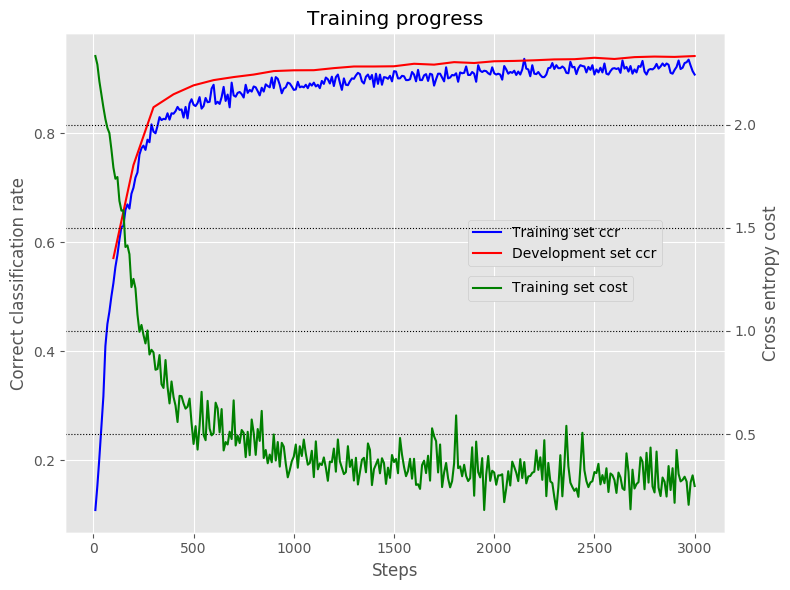

Evaluating train set
CCR = 50776 / 55000 = 0.9232
Evaluating development set
CCR =  4709 /  5000 = 0.9418
Evaluating test set
CCR =  9235 / 10000 = 0.9235


In [12]:
# Import the module

import src.main as main
import src.run as run

# Import config, and do changes if you want to
conf = main.config_mnist()
conf['max_steps'] = 3000

X_train, Y_train, X_devel, Y_devel, X_test, Y_test = main.get_data(conf)

params, train_progress, devel_progress = run.train(conf, X_train, Y_train, X_devel, Y_devel)

main.plot_progress(train_progress, devel_progress)

print("Evaluating train set")
num_correct, num_evaluated = run.evaluate(conf, params, X_train, Y_train)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))
print("Evaluating development set")
num_correct, num_evaluated = run.evaluate(conf, params, X_devel, Y_devel)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))
print("Evaluating test set")
num_correct, num_evaluated = run.evaluate(conf, params, X_test, Y_test)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))


#### CIFAR10

Loading cifar10 data from /tmp/data\cifar10
Extracting tar file: /tmp/data\cifar10\cifar-10-python.tar.gz
Run training
Number of training examples in one epoch:  45000
Start training
Terminating training after 3000 steps


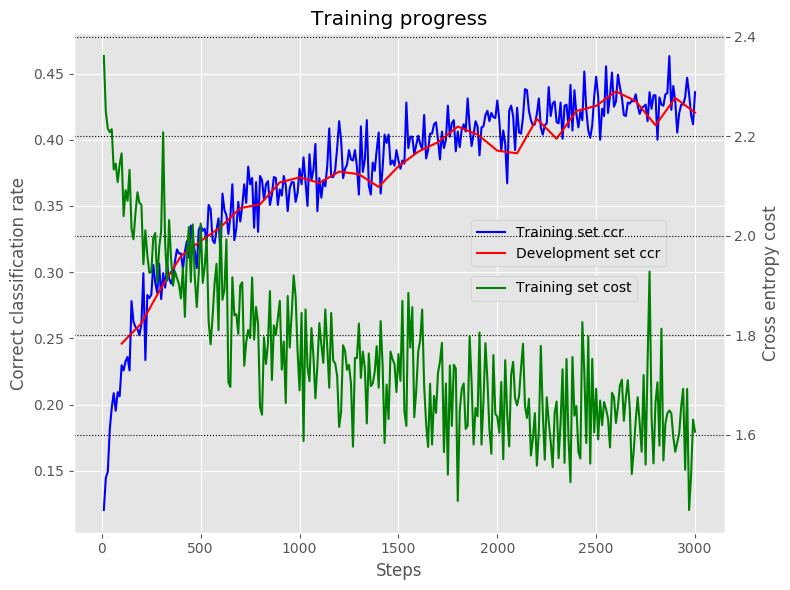

Evaluating train set
CCR = 19508 / 45000 = 0.4335
Evaluating development set
CCR =  2103 /  5000 = 0.4206
Evaluating test set
CCR =  4248 / 10000 = 0.4248


In [14]:
# Import the module

import src.main as main
import src.run as run

# Import config, and do changes if you want to
conf = main.config_cifar10()
conf['max_steps'] = 3000

X_train, Y_train, X_devel, Y_devel, X_test, Y_test = main.get_data(conf)

params, train_progress, devel_progress = run.train(conf, X_train, Y_train, X_devel, Y_devel)

main.plot_progress(train_progress, devel_progress)

print("Evaluating train set")
num_correct, num_evaluated = run.evaluate(conf, params, X_train, Y_train)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))
print("Evaluating development set")
num_correct, num_evaluated = run.evaluate(conf, params, X_devel, Y_devel)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))
print("Evaluating test set")
num_correct, num_evaluated = run.evaluate(conf, params, X_test, Y_test)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))


#### SVNH

Loading svhn data from /tmp/data\svhn
Run training
Number of training examples in one epoch:  68257
Start training
Terminating training after 3000 steps


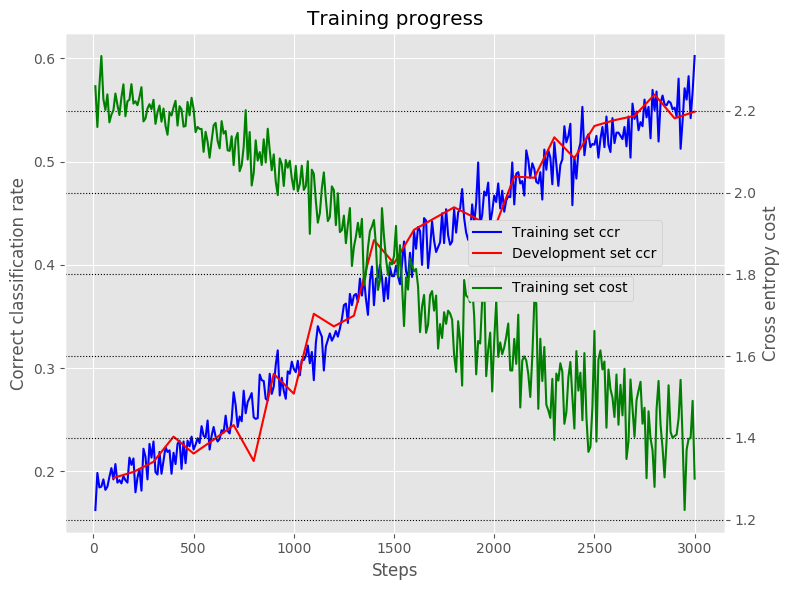

Evaluating train set
CCR = 38340 / 68257 = 0.5617
Evaluating development set
CCR =  2742 /  5000 = 0.5484
Evaluating test set
CCR = 14093 / 26032 = 0.5414


In [17]:
# Import the module

import src.main as main
import src.run as run

# Import config, and do changes if you want to
conf = main.config_svhn()
conf['max_steps'] = 3000

X_train, Y_train, X_devel, Y_devel, X_test, Y_test = main.get_data(conf)

params, train_progress, devel_progress = run.train(conf, X_train, Y_train, X_devel, Y_devel)

main.plot_progress(train_progress, devel_progress)

print("Evaluating train set")
num_correct, num_evaluated = run.evaluate(conf, params, X_train, Y_train)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))
print("Evaluating development set")
num_correct, num_evaluated = run.evaluate(conf, params, X_devel, Y_devel)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))
print("Evaluating test set")
num_correct, num_evaluated = run.evaluate(conf, params, X_test, Y_test)
print("CCR = {0:>5} / {1:>5} = {2:>6.4f}".format(num_correct, num_evaluated,
                                                 num_correct/num_evaluated))


### Task 6 b): Exceed results

Experiment with different configurations and try to beat the classification results above. We expect you to experiment a bit, and to give an effort in improving the results, but you will not be judged by whether you managed to exceed the results or not.

Suggested things to edit are listed below. Some are available if you have implemented everything in this assignment correctly, others will need some extra implementation. 

- Out of the box
  - Step length (learning rate)
  - Number of layers
  - Number of nodes in the layers
  - Number of training steps
- Things you have to implement yourself
  - Activation function
  - Parameter initialization
  - Optimization routine
  - Data standardization
  
Report your results, in addition to the configuration used, in cells below this one.